# Methane Working Capacity prediction using Machine Learning 
    1.1 Import package
    1.2 Set variable
    2.1 Divid dataset(Diversity Selection) and Save divided dataset
    2.2 Load divided dataset
    2.3 Plot feature distribution 
    3.1 Train model(Gradient Boosting Regression) and Save training model
    3.2 Load feature importance from saved model
    3.3 Plot feature importances
    
## Necessary Process 1.1, 1.2, 2.2, 3.2


## 1.1 Import package

In [1]:
import random
import csv
import sys
import time
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import expanduser
home = expanduser("~")

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
#from sklearn.externals import joblib
import joblib
import pickle

## 1.2  Set variable

In [2]:
file_name='Methane_merge_AGSA'
data_file_name="./"+file_name+".csv" 
feature_num=6
diverse_ratio=0.8 # training set ratio, 
remaining_ratio=1-diverse_ratio # test set ratio
random.seed(40)
cases=['LNG_ANG','ANG','5bar','6bar','65bar']

## 2.1 Divid dataset (Diversity Selection) and Save divided dataset

In [8]:
with open(data_file_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        n_samples = int(temp[0])
        N_features = int(temp[1])
        if N_features != feature_num:
            print("N_features is not"+str(feature_num))
            sys.exit()
        data = np.empty((n_samples, N_features))
        temp = next(data_file)
        feature_list=temp[:N_features]
        for i, d in enumerate(data_file):
            data[i] = np.asarray(d[:feature_num], dtype=np.float64)
print("Total number of materials : ", data.shape[0])
N_materials = data.shape[0]


print("Number of features: ", N_features)
feature_0 = data.T[0]
feature_1 = data.T[1]
feature_2 = data.T[2]
feature_3 = data.T[3]
feature_4 = data.T[4]
feature_5 = data.T[5]
# rescale
feature_0 = (feature_0 - np.min(feature_0))/(np.max(feature_0) - np.min(feature_0))
feature_1 = (feature_1 - np.min(feature_1))/(np.max(feature_1) - np.min(feature_1))
feature_2 = (feature_2 - np.min(feature_2))/(np.max(feature_2) - np.min(feature_2))
feature_3 = (feature_3 - np.min(feature_3))/(np.max(feature_3) - np.min(feature_3))
feature_4 = (feature_4 - np.min(feature_4))/(np.max(feature_4) - np.min(feature_4))
feature_5 = (feature_5 - np.min(feature_5))/(np.max(feature_5) - np.min(feature_5))

if N_features == 5:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials)))
if N_features == 6:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials),feature_5.reshape(1,N_materials)))
if N_features == 7:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials),feature_5.reshape(1,N_materials),feature_6.reshape(1,N_materials)))
    
print("Shape of feature x: ", np.shape(x))
print("Example feature vector = " , x[:,0])
N_sample = int(N_materials * diverse_ratio)-1

print("Sampling %d diverse structures out of %d" % (N_sample+1,N_materials))
print("total accessible materials considered: ", N_materials)



print("Starting diversity selection. Seeking %d points" % (N_sample+1))
time.sleep(1)
# store indices of x here for the diverse and non-diverse sets.
diverse_set = []
remaining_set = list(range(N_materials))
# INITIALIZE WITH RANDOMLY SELECTED POINT
idx_init = random.sample(list(np.arange(N_materials)),1)[0]
diverse_set.append(idx_init)
remaining_set.remove(idx_init)
N_diverse = 1
while N_diverse <= N_sample:
        print("Selecting point ", N_diverse)
        min_d_to_diverse_set = np.zeros((N_materials-N_diverse,))
        # for every candidate point not in diverse set...
        for i in range(N_materials - N_diverse):
            # get the distance of this point to each point in the diverse set
            d_from_each_diverse_pt = np.linalg.norm(x[:,diverse_set] - x[:,remaining_set[i]].reshape(N_features,1),axis=0)
            # get the closest distance that this point is to the diverse set
            min_d_to_diverse_set[i] = np.min(d_from_each_diverse_pt)
        # select point that has the largest distance from the diverse set
        idx_select = remaining_set[np.argmax(min_d_to_diverse_set)]
        assert (len(remaining_set) == np.size(min_d_to_diverse_set))
        print("\tSelected point " , idx_select)
        # add point to diverse set; remove it from remaining set
        diverse_set.append(idx_select)
        remaining_set.remove(idx_select)
        print("\tPts in diverse set: ", len(diverse_set))
        print("\tPts in remaining set: ", len(remaining_set))
        print(diverse_set[N_diverse-1])
        N_diverse += 1

with open("divided_set_"+str(diverse_ratio)+"_"+str("%.1f" %(remaining_ratio))+"_"+str(feature_num)+"_"+file_name+"feature.txt", "w") as f:
    f.write(str(diverse_set)+" "+str(remaining_set))
    
    print("Save file name : divided_set_"+str(diverse_ratio)+"_"+str("%.1f" %(remaining_ratio))+"_"+str(N_features)+"_"+file_name+"feature.txt")


Total number of materials :  5517
Number of features:  6
Shape of feature x:  (6, 5517)
Example feature vector =  [0.19664249 0.08990957 0.51485791 0.10876705 0.86371681 0.85900424]
Sampling 4413 diverse structures out of 5517
total accessible materials considered:  5517
Starting diversity selection. Seeking 4413 points
Selecting point  1
	Selected point  5341
	Pts in diverse set:  2
	Pts in remaining set:  5515
3756
Selecting point  2
	Selected point  1291
	Pts in diverse set:  3
	Pts in remaining set:  5514
5341
Selecting point  3
	Selected point  422
	Pts in diverse set:  4
	Pts in remaining set:  5513
1291
Selecting point  4
	Selected point  4002
	Pts in diverse set:  5
	Pts in remaining set:  5512
422
Selecting point  5
	Selected point  2377
	Pts in diverse set:  6
	Pts in remaining set:  5511
4002
Selecting point  6
	Selected point  2329
	Pts in diverse set:  7
	Pts in remaining set:  5510
2377
Selecting point  7
	Selected point  5245
	Pts in diverse set:  8
	Pts in remaining set

	Selected point  2497
	Pts in diverse set:  81
	Pts in remaining set:  5436
5464
Selecting point  81
	Selected point  738
	Pts in diverse set:  82
	Pts in remaining set:  5435
2497
Selecting point  82
	Selected point  2131
	Pts in diverse set:  83
	Pts in remaining set:  5434
738
Selecting point  83
	Selected point  2536
	Pts in diverse set:  84
	Pts in remaining set:  5433
2131
Selecting point  84
	Selected point  5466
	Pts in diverse set:  85
	Pts in remaining set:  5432
2536
Selecting point  85
	Selected point  2698
	Pts in diverse set:  86
	Pts in remaining set:  5431
5466
Selecting point  86
	Selected point  3256
	Pts in diverse set:  87
	Pts in remaining set:  5430
2698
Selecting point  87
	Selected point  4000
	Pts in diverse set:  88
	Pts in remaining set:  5429
3256
Selecting point  88
	Selected point  1129
	Pts in diverse set:  89
	Pts in remaining set:  5428
4000
Selecting point  89
	Selected point  4835
	Pts in diverse set:  90
	Pts in remaining set:  5427
1129
Selecting po

	Selected point  2298
	Pts in diverse set:  163
	Pts in remaining set:  5354
571
Selecting point  163
	Selected point  20
	Pts in diverse set:  164
	Pts in remaining set:  5353
2298
Selecting point  164
	Selected point  2690
	Pts in diverse set:  165
	Pts in remaining set:  5352
20
Selecting point  165
	Selected point  4536
	Pts in diverse set:  166
	Pts in remaining set:  5351
2690
Selecting point  166
	Selected point  355
	Pts in diverse set:  167
	Pts in remaining set:  5350
4536
Selecting point  167
	Selected point  2946
	Pts in diverse set:  168
	Pts in remaining set:  5349
355
Selecting point  168
	Selected point  2246
	Pts in diverse set:  169
	Pts in remaining set:  5348
2946
Selecting point  169
	Selected point  19
	Pts in diverse set:  170
	Pts in remaining set:  5347
2246
Selecting point  170
	Selected point  1123
	Pts in diverse set:  171
	Pts in remaining set:  5346
19
Selecting point  171
	Selected point  3629
	Pts in diverse set:  172
	Pts in remaining set:  5345
1123
Se

	Selected point  5471
	Pts in diverse set:  245
	Pts in remaining set:  5272
1499
Selecting point  245
	Selected point  3197
	Pts in diverse set:  246
	Pts in remaining set:  5271
5471
Selecting point  246
	Selected point  4692
	Pts in diverse set:  247
	Pts in remaining set:  5270
3197
Selecting point  247
	Selected point  5353
	Pts in diverse set:  248
	Pts in remaining set:  5269
4692
Selecting point  248
	Selected point  188
	Pts in diverse set:  249
	Pts in remaining set:  5268
5353
Selecting point  249
	Selected point  2528
	Pts in diverse set:  250
	Pts in remaining set:  5267
188
Selecting point  250
	Selected point  3722
	Pts in diverse set:  251
	Pts in remaining set:  5266
2528
Selecting point  251
	Selected point  2421
	Pts in diverse set:  252
	Pts in remaining set:  5265
3722
Selecting point  252
	Selected point  3649
	Pts in diverse set:  253
	Pts in remaining set:  5264
2421
Selecting point  253
	Selected point  2771
	Pts in diverse set:  254
	Pts in remaining set:  526

	Selected point  1725
	Pts in diverse set:  326
	Pts in remaining set:  5191
129
Selecting point  326
	Selected point  5484
	Pts in diverse set:  327
	Pts in remaining set:  5190
1725
Selecting point  327
	Selected point  5402
	Pts in diverse set:  328
	Pts in remaining set:  5189
5484
Selecting point  328
	Selected point  575
	Pts in diverse set:  329
	Pts in remaining set:  5188
5402
Selecting point  329
	Selected point  2022
	Pts in diverse set:  330
	Pts in remaining set:  5187
575
Selecting point  330
	Selected point  798
	Pts in diverse set:  331
	Pts in remaining set:  5186
2022
Selecting point  331
	Selected point  2454
	Pts in diverse set:  332
	Pts in remaining set:  5185
798
Selecting point  332
	Selected point  531
	Pts in diverse set:  333
	Pts in remaining set:  5184
2454
Selecting point  333
	Selected point  1807
	Pts in diverse set:  334
	Pts in remaining set:  5183
531
Selecting point  334
	Selected point  235
	Pts in diverse set:  335
	Pts in remaining set:  5182
1807

	Selected point  515
	Pts in diverse set:  406
	Pts in remaining set:  5111
4353
Selecting point  406
	Selected point  1744
	Pts in diverse set:  407
	Pts in remaining set:  5110
515
Selecting point  407
	Selected point  4594
	Pts in diverse set:  408
	Pts in remaining set:  5109
1744
Selecting point  408
	Selected point  4320
	Pts in diverse set:  409
	Pts in remaining set:  5108
4594
Selecting point  409
	Selected point  1724
	Pts in diverse set:  410
	Pts in remaining set:  5107
4320
Selecting point  410
	Selected point  5390
	Pts in diverse set:  411
	Pts in remaining set:  5106
1724
Selecting point  411
	Selected point  5496
	Pts in diverse set:  412
	Pts in remaining set:  5105
5390
Selecting point  412
	Selected point  1045
	Pts in diverse set:  413
	Pts in remaining set:  5104
5496
Selecting point  413
	Selected point  3618
	Pts in diverse set:  414
	Pts in remaining set:  5103
1045
Selecting point  414
	Selected point  5158
	Pts in diverse set:  415
	Pts in remaining set:  510

	Selected point  4998
	Pts in diverse set:  486
	Pts in remaining set:  5031
2492
Selecting point  486
	Selected point  3113
	Pts in diverse set:  487
	Pts in remaining set:  5030
4998
Selecting point  487
	Selected point  5312
	Pts in diverse set:  488
	Pts in remaining set:  5029
3113
Selecting point  488
	Selected point  2361
	Pts in diverse set:  489
	Pts in remaining set:  5028
5312
Selecting point  489
	Selected point  8
	Pts in diverse set:  490
	Pts in remaining set:  5027
2361
Selecting point  490
	Selected point  148
	Pts in diverse set:  491
	Pts in remaining set:  5026
8
Selecting point  491
	Selected point  3782
	Pts in diverse set:  492
	Pts in remaining set:  5025
148
Selecting point  492
	Selected point  1064
	Pts in diverse set:  493
	Pts in remaining set:  5024
3782
Selecting point  493
	Selected point  860
	Pts in diverse set:  494
	Pts in remaining set:  5023
1064
Selecting point  494
	Selected point  2287
	Pts in diverse set:  495
	Pts in remaining set:  5022
860
S

	Selected point  3223
	Pts in diverse set:  566
	Pts in remaining set:  4951
3585
Selecting point  566
	Selected point  5260
	Pts in diverse set:  567
	Pts in remaining set:  4950
3223
Selecting point  567
	Selected point  681
	Pts in diverse set:  568
	Pts in remaining set:  4949
5260
Selecting point  568
	Selected point  3260
	Pts in diverse set:  569
	Pts in remaining set:  4948
681
Selecting point  569
	Selected point  5467
	Pts in diverse set:  570
	Pts in remaining set:  4947
3260
Selecting point  570
	Selected point  4868
	Pts in diverse set:  571
	Pts in remaining set:  4946
5467
Selecting point  571
	Selected point  4764
	Pts in diverse set:  572
	Pts in remaining set:  4945
4868
Selecting point  572
	Selected point  1834
	Pts in diverse set:  573
	Pts in remaining set:  4944
4764
Selecting point  573
	Selected point  3202
	Pts in diverse set:  574
	Pts in remaining set:  4943
1834
Selecting point  574
	Selected point  1417
	Pts in diverse set:  575
	Pts in remaining set:  494

	Selected point  1805
	Pts in diverse set:  646
	Pts in remaining set:  4871
5318
Selecting point  646
	Selected point  2864
	Pts in diverse set:  647
	Pts in remaining set:  4870
1805
Selecting point  647
	Selected point  2218
	Pts in diverse set:  648
	Pts in remaining set:  4869
2864
Selecting point  648
	Selected point  5173
	Pts in diverse set:  649
	Pts in remaining set:  4868
2218
Selecting point  649
	Selected point  0
	Pts in diverse set:  650
	Pts in remaining set:  4867
5173
Selecting point  650
	Selected point  935
	Pts in diverse set:  651
	Pts in remaining set:  4866
0
Selecting point  651
	Selected point  2149
	Pts in diverse set:  652
	Pts in remaining set:  4865
935
Selecting point  652
	Selected point  5417
	Pts in diverse set:  653
	Pts in remaining set:  4864
2149
Selecting point  653
	Selected point  3575
	Pts in diverse set:  654
	Pts in remaining set:  4863
5417
Selecting point  654
	Selected point  1385
	Pts in diverse set:  655
	Pts in remaining set:  4862
3575

	Selected point  4857
	Pts in diverse set:  727
	Pts in remaining set:  4790
948
Selecting point  727
	Selected point  4874
	Pts in diverse set:  728
	Pts in remaining set:  4789
4857
Selecting point  728
	Selected point  4517
	Pts in diverse set:  729
	Pts in remaining set:  4788
4874
Selecting point  729
	Selected point  3353
	Pts in diverse set:  730
	Pts in remaining set:  4787
4517
Selecting point  730
	Selected point  2736
	Pts in diverse set:  731
	Pts in remaining set:  4786
3353
Selecting point  731
	Selected point  5277
	Pts in diverse set:  732
	Pts in remaining set:  4785
2736
Selecting point  732
	Selected point  950
	Pts in diverse set:  733
	Pts in remaining set:  4784
5277
Selecting point  733
	Selected point  4125
	Pts in diverse set:  734
	Pts in remaining set:  4783
950
Selecting point  734
	Selected point  5247
	Pts in diverse set:  735
	Pts in remaining set:  4782
4125
Selecting point  735
	Selected point  1141
	Pts in diverse set:  736
	Pts in remaining set:  4781

	Selected point  4627
	Pts in diverse set:  807
	Pts in remaining set:  4710
5191
Selecting point  807
	Selected point  3233
	Pts in diverse set:  808
	Pts in remaining set:  4709
4627
Selecting point  808
	Selected point  244
	Pts in diverse set:  809
	Pts in remaining set:  4708
3233
Selecting point  809
	Selected point  4421
	Pts in diverse set:  810
	Pts in remaining set:  4707
244
Selecting point  810
	Selected point  1774
	Pts in diverse set:  811
	Pts in remaining set:  4706
4421
Selecting point  811
	Selected point  4305
	Pts in diverse set:  812
	Pts in remaining set:  4705
1774
Selecting point  812
	Selected point  1067
	Pts in diverse set:  813
	Pts in remaining set:  4704
4305
Selecting point  813
	Selected point  1870
	Pts in diverse set:  814
	Pts in remaining set:  4703
1067
Selecting point  814
	Selected point  3654
	Pts in diverse set:  815
	Pts in remaining set:  4702
1870
Selecting point  815
	Selected point  3938
	Pts in diverse set:  816
	Pts in remaining set:  470

	Selected point  981
	Pts in diverse set:  887
	Pts in remaining set:  4630
2920
Selecting point  887
	Selected point  207
	Pts in diverse set:  888
	Pts in remaining set:  4629
981
Selecting point  888
	Selected point  1572
	Pts in diverse set:  889
	Pts in remaining set:  4628
207
Selecting point  889
	Selected point  1139
	Pts in diverse set:  890
	Pts in remaining set:  4627
1572
Selecting point  890
	Selected point  3788
	Pts in diverse set:  891
	Pts in remaining set:  4626
1139
Selecting point  891
	Selected point  5168
	Pts in diverse set:  892
	Pts in remaining set:  4625
3788
Selecting point  892
	Selected point  1261
	Pts in diverse set:  893
	Pts in remaining set:  4624
5168
Selecting point  893
	Selected point  3083
	Pts in diverse set:  894
	Pts in remaining set:  4623
1261
Selecting point  894
	Selected point  4948
	Pts in diverse set:  895
	Pts in remaining set:  4622
3083
Selecting point  895
	Selected point  2765
	Pts in diverse set:  896
	Pts in remaining set:  4621


	Selected point  4873
	Pts in diverse set:  967
	Pts in remaining set:  4550
1216
Selecting point  967
	Selected point  4117
	Pts in diverse set:  968
	Pts in remaining set:  4549
4873
Selecting point  968
	Selected point  884
	Pts in diverse set:  969
	Pts in remaining set:  4548
4117
Selecting point  969
	Selected point  4505
	Pts in diverse set:  970
	Pts in remaining set:  4547
884
Selecting point  970
	Selected point  4071
	Pts in diverse set:  971
	Pts in remaining set:  4546
4505
Selecting point  971
	Selected point  2227
	Pts in diverse set:  972
	Pts in remaining set:  4545
4071
Selecting point  972
	Selected point  4293
	Pts in diverse set:  973
	Pts in remaining set:  4544
2227
Selecting point  973
	Selected point  827
	Pts in diverse set:  974
	Pts in remaining set:  4543
4293
Selecting point  974
	Selected point  912
	Pts in diverse set:  975
	Pts in remaining set:  4542
827
Selecting point  975
	Selected point  985
	Pts in diverse set:  976
	Pts in remaining set:  4541
91

	Selected point  2711
	Pts in diverse set:  1047
	Pts in remaining set:  4470
5139
Selecting point  1047
	Selected point  1169
	Pts in diverse set:  1048
	Pts in remaining set:  4469
2711
Selecting point  1048
	Selected point  3992
	Pts in diverse set:  1049
	Pts in remaining set:  4468
1169
Selecting point  1049
	Selected point  4785
	Pts in diverse set:  1050
	Pts in remaining set:  4467
3992
Selecting point  1050
	Selected point  1949
	Pts in diverse set:  1051
	Pts in remaining set:  4466
4785
Selecting point  1051
	Selected point  4954
	Pts in diverse set:  1052
	Pts in remaining set:  4465
1949
Selecting point  1052
	Selected point  5089
	Pts in diverse set:  1053
	Pts in remaining set:  4464
4954
Selecting point  1053
	Selected point  62
	Pts in diverse set:  1054
	Pts in remaining set:  4463
5089
Selecting point  1054
	Selected point  108
	Pts in diverse set:  1055
	Pts in remaining set:  4462
62
Selecting point  1055
	Selected point  1738
	Pts in diverse set:  1056
	Pts in rem

	Selected point  5240
	Pts in diverse set:  1126
	Pts in remaining set:  4391
3068
Selecting point  1126
	Selected point  3409
	Pts in diverse set:  1127
	Pts in remaining set:  4390
5240
Selecting point  1127
	Selected point  909
	Pts in diverse set:  1128
	Pts in remaining set:  4389
3409
Selecting point  1128
	Selected point  2866
	Pts in diverse set:  1129
	Pts in remaining set:  4388
909
Selecting point  1129
	Selected point  1702
	Pts in diverse set:  1130
	Pts in remaining set:  4387
2866
Selecting point  1130
	Selected point  5321
	Pts in diverse set:  1131
	Pts in remaining set:  4386
1702
Selecting point  1131
	Selected point  1754
	Pts in diverse set:  1132
	Pts in remaining set:  4385
5321
Selecting point  1132
	Selected point  2935
	Pts in diverse set:  1133
	Pts in remaining set:  4384
1754
Selecting point  1133
	Selected point  693
	Pts in diverse set:  1134
	Pts in remaining set:  4383
2935
Selecting point  1134
	Selected point  3280
	Pts in diverse set:  1135
	Pts in r

	Selected point  766
	Pts in diverse set:  1205
	Pts in remaining set:  4312
3357
Selecting point  1205
	Selected point  391
	Pts in diverse set:  1206
	Pts in remaining set:  4311
766
Selecting point  1206
	Selected point  523
	Pts in diverse set:  1207
	Pts in remaining set:  4310
391
Selecting point  1207
	Selected point  5248
	Pts in diverse set:  1208
	Pts in remaining set:  4309
523
Selecting point  1208
	Selected point  2750
	Pts in diverse set:  1209
	Pts in remaining set:  4308
5248
Selecting point  1209
	Selected point  1780
	Pts in diverse set:  1210
	Pts in remaining set:  4307
2750
Selecting point  1210
	Selected point  2996
	Pts in diverse set:  1211
	Pts in remaining set:  4306
1780
Selecting point  1211
	Selected point  988
	Pts in diverse set:  1212
	Pts in remaining set:  4305
2996
Selecting point  1212
	Selected point  2373
	Pts in diverse set:  1213
	Pts in remaining set:  4304
988
Selecting point  1213
	Selected point  2597
	Pts in diverse set:  1214
	Pts in remain

	Selected point  274
	Pts in diverse set:  1284
	Pts in remaining set:  4233
4541
Selecting point  1284
	Selected point  525
	Pts in diverse set:  1285
	Pts in remaining set:  4232
274
Selecting point  1285
	Selected point  741
	Pts in diverse set:  1286
	Pts in remaining set:  4231
525
Selecting point  1286
	Selected point  2392
	Pts in diverse set:  1287
	Pts in remaining set:  4230
741
Selecting point  1287
	Selected point  1158
	Pts in diverse set:  1288
	Pts in remaining set:  4229
2392
Selecting point  1288
	Selected point  2391
	Pts in diverse set:  1289
	Pts in remaining set:  4228
1158
Selecting point  1289
	Selected point  728
	Pts in diverse set:  1290
	Pts in remaining set:  4227
2391
Selecting point  1290
	Selected point  989
	Pts in diverse set:  1291
	Pts in remaining set:  4226
728
Selecting point  1291
	Selected point  5377
	Pts in diverse set:  1292
	Pts in remaining set:  4225
989
Selecting point  1292
	Selected point  85
	Pts in diverse set:  1293
	Pts in remaining 

	Selected point  353
	Pts in diverse set:  1363
	Pts in remaining set:  4154
2845
Selecting point  1363
	Selected point  1788
	Pts in diverse set:  1364
	Pts in remaining set:  4153
353
Selecting point  1364
	Selected point  4260
	Pts in diverse set:  1365
	Pts in remaining set:  4152
1788
Selecting point  1365
	Selected point  4713
	Pts in diverse set:  1366
	Pts in remaining set:  4151
4260
Selecting point  1366
	Selected point  2042
	Pts in diverse set:  1367
	Pts in remaining set:  4150
4713
Selecting point  1367
	Selected point  4547
	Pts in diverse set:  1368
	Pts in remaining set:  4149
2042
Selecting point  1368
	Selected point  5037
	Pts in diverse set:  1369
	Pts in remaining set:  4148
4547
Selecting point  1369
	Selected point  1923
	Pts in diverse set:  1370
	Pts in remaining set:  4147
5037
Selecting point  1370
	Selected point  784
	Pts in diverse set:  1371
	Pts in remaining set:  4146
1923
Selecting point  1371
	Selected point  2110
	Pts in diverse set:  1372
	Pts in r

	Selected point  2626
	Pts in diverse set:  1442
	Pts in remaining set:  4075
4003
Selecting point  1442
	Selected point  2121
	Pts in diverse set:  1443
	Pts in remaining set:  4074
2626
Selecting point  1443
	Selected point  5098
	Pts in diverse set:  1444
	Pts in remaining set:  4073
2121
Selecting point  1444
	Selected point  3704
	Pts in diverse set:  1445
	Pts in remaining set:  4072
5098
Selecting point  1445
	Selected point  438
	Pts in diverse set:  1446
	Pts in remaining set:  4071
3704
Selecting point  1446
	Selected point  3569
	Pts in diverse set:  1447
	Pts in remaining set:  4070
438
Selecting point  1447
	Selected point  1324
	Pts in diverse set:  1448
	Pts in remaining set:  4069
3569
Selecting point  1448
	Selected point  263
	Pts in diverse set:  1449
	Pts in remaining set:  4068
1324
Selecting point  1449
	Selected point  3631
	Pts in diverse set:  1450
	Pts in remaining set:  4067
263
Selecting point  1450
	Selected point  2647
	Pts in diverse set:  1451
	Pts in re

	Selected point  2283
	Pts in diverse set:  1521
	Pts in remaining set:  3996
3183
Selecting point  1521
	Selected point  4331
	Pts in diverse set:  1522
	Pts in remaining set:  3995
2283
Selecting point  1522
	Selected point  1941
	Pts in diverse set:  1523
	Pts in remaining set:  3994
4331
Selecting point  1523
	Selected point  4455
	Pts in diverse set:  1524
	Pts in remaining set:  3993
1941
Selecting point  1524
	Selected point  3284
	Pts in diverse set:  1525
	Pts in remaining set:  3992
4455
Selecting point  1525
	Selected point  192
	Pts in diverse set:  1526
	Pts in remaining set:  3991
3284
Selecting point  1526
	Selected point  2948
	Pts in diverse set:  1527
	Pts in remaining set:  3990
192
Selecting point  1527
	Selected point  278
	Pts in diverse set:  1528
	Pts in remaining set:  3989
2948
Selecting point  1528
	Selected point  3337
	Pts in diverse set:  1529
	Pts in remaining set:  3988
278
Selecting point  1529
	Selected point  3645
	Pts in diverse set:  1530
	Pts in re

	Selected point  1717
	Pts in diverse set:  1600
	Pts in remaining set:  3917
4888
Selecting point  1600
	Selected point  3930
	Pts in diverse set:  1601
	Pts in remaining set:  3916
1717
Selecting point  1601
	Selected point  2215
	Pts in diverse set:  1602
	Pts in remaining set:  3915
3930
Selecting point  1602
	Selected point  1821
	Pts in diverse set:  1603
	Pts in remaining set:  3914
2215
Selecting point  1603
	Selected point  2068
	Pts in diverse set:  1604
	Pts in remaining set:  3913
1821
Selecting point  1604
	Selected point  2267
	Pts in diverse set:  1605
	Pts in remaining set:  3912
2068
Selecting point  1605
	Selected point  5189
	Pts in diverse set:  1606
	Pts in remaining set:  3911
2267
Selecting point  1606
	Selected point  2568
	Pts in diverse set:  1607
	Pts in remaining set:  3910
5189
Selecting point  1607
	Selected point  15
	Pts in diverse set:  1608
	Pts in remaining set:  3909
2568
Selecting point  1608
	Selected point  352
	Pts in diverse set:  1609
	Pts in r

	Selected point  4841
	Pts in diverse set:  1679
	Pts in remaining set:  3838
4952
Selecting point  1679
	Selected point  1660
	Pts in diverse set:  1680
	Pts in remaining set:  3837
4841
Selecting point  1680
	Selected point  2891
	Pts in diverse set:  1681
	Pts in remaining set:  3836
1660
Selecting point  1681
	Selected point  1847
	Pts in diverse set:  1682
	Pts in remaining set:  3835
2891
Selecting point  1682
	Selected point  595
	Pts in diverse set:  1683
	Pts in remaining set:  3834
1847
Selecting point  1683
	Selected point  1688
	Pts in diverse set:  1684
	Pts in remaining set:  3833
595
Selecting point  1684
	Selected point  1997
	Pts in diverse set:  1685
	Pts in remaining set:  3832
1688
Selecting point  1685
	Selected point  1826
	Pts in diverse set:  1686
	Pts in remaining set:  3831
1997
Selecting point  1686
	Selected point  286
	Pts in diverse set:  1687
	Pts in remaining set:  3830
1826
Selecting point  1687
	Selected point  3906
	Pts in diverse set:  1688
	Pts in r

	Selected point  4144
	Pts in diverse set:  1758
	Pts in remaining set:  3759
3975
Selecting point  1758
	Selected point  3635
	Pts in diverse set:  1759
	Pts in remaining set:  3758
4144
Selecting point  1759
	Selected point  134
	Pts in diverse set:  1760
	Pts in remaining set:  3757
3635
Selecting point  1760
	Selected point  991
	Pts in diverse set:  1761
	Pts in remaining set:  3756
134
Selecting point  1761
	Selected point  1306
	Pts in diverse set:  1762
	Pts in remaining set:  3755
991
Selecting point  1762
	Selected point  5055
	Pts in diverse set:  1763
	Pts in remaining set:  3754
1306
Selecting point  1763
	Selected point  3423
	Pts in diverse set:  1764
	Pts in remaining set:  3753
5055
Selecting point  1764
	Selected point  3700
	Pts in diverse set:  1765
	Pts in remaining set:  3752
3423
Selecting point  1765
	Selected point  2115
	Pts in diverse set:  1766
	Pts in remaining set:  3751
3700
Selecting point  1766
	Selected point  3780
	Pts in diverse set:  1767
	Pts in re

	Selected point  433
	Pts in diverse set:  1837
	Pts in remaining set:  3680
4347
Selecting point  1837
	Selected point  4848
	Pts in diverse set:  1838
	Pts in remaining set:  3679
433
Selecting point  1838
	Selected point  216
	Pts in diverse set:  1839
	Pts in remaining set:  3678
4848
Selecting point  1839
	Selected point  214
	Pts in diverse set:  1840
	Pts in remaining set:  3677
216
Selecting point  1840
	Selected point  205
	Pts in diverse set:  1841
	Pts in remaining set:  3676
214
Selecting point  1841
	Selected point  1469
	Pts in diverse set:  1842
	Pts in remaining set:  3675
205
Selecting point  1842
	Selected point  297
	Pts in diverse set:  1843
	Pts in remaining set:  3674
1469
Selecting point  1843
	Selected point  3556
	Pts in diverse set:  1844
	Pts in remaining set:  3673
297
Selecting point  1844
	Selected point  3138
	Pts in diverse set:  1845
	Pts in remaining set:  3672
3556
Selecting point  1845
	Selected point  1904
	Pts in diverse set:  1846
	Pts in remainin

	Selected point  37
	Pts in diverse set:  1916
	Pts in remaining set:  3601
1430
Selecting point  1916
	Selected point  309
	Pts in diverse set:  1917
	Pts in remaining set:  3600
37
Selecting point  1917
	Selected point  4491
	Pts in diverse set:  1918
	Pts in remaining set:  3599
309
Selecting point  1918
	Selected point  3045
	Pts in diverse set:  1919
	Pts in remaining set:  3598
4491
Selecting point  1919
	Selected point  4246
	Pts in diverse set:  1920
	Pts in remaining set:  3597
3045
Selecting point  1920
	Selected point  5217
	Pts in diverse set:  1921
	Pts in remaining set:  3596
4246
Selecting point  1921
	Selected point  3703
	Pts in diverse set:  1922
	Pts in remaining set:  3595
5217
Selecting point  1922
	Selected point  4777
	Pts in diverse set:  1923
	Pts in remaining set:  3594
3703
Selecting point  1923
	Selected point  5075
	Pts in diverse set:  1924
	Pts in remaining set:  3593
4777
Selecting point  1924
	Selected point  1240
	Pts in diverse set:  1925
	Pts in rema

	Selected point  4679
	Pts in diverse set:  1995
	Pts in remaining set:  3522
690
Selecting point  1995
	Selected point  5004
	Pts in diverse set:  1996
	Pts in remaining set:  3521
4679
Selecting point  1996
	Selected point  4143
	Pts in diverse set:  1997
	Pts in remaining set:  3520
5004
Selecting point  1997
	Selected point  1708
	Pts in diverse set:  1998
	Pts in remaining set:  3519
4143
Selecting point  1998
	Selected point  2761
	Pts in diverse set:  1999
	Pts in remaining set:  3518
1708
Selecting point  1999
	Selected point  1107
	Pts in diverse set:  2000
	Pts in remaining set:  3517
2761
Selecting point  2000
	Selected point  3452
	Pts in diverse set:  2001
	Pts in remaining set:  3516
1107
Selecting point  2001
	Selected point  162
	Pts in diverse set:  2002
	Pts in remaining set:  3515
3452
Selecting point  2002
	Selected point  3974
	Pts in diverse set:  2003
	Pts in remaining set:  3514
162
Selecting point  2003
	Selected point  3320
	Pts in diverse set:  2004
	Pts in r

	Selected point  473
	Pts in diverse set:  2074
	Pts in remaining set:  3443
2525
Selecting point  2074
	Selected point  1854
	Pts in diverse set:  2075
	Pts in remaining set:  3442
473
Selecting point  2075
	Selected point  4979
	Pts in diverse set:  2076
	Pts in remaining set:  3441
1854
Selecting point  2076
	Selected point  4543
	Pts in diverse set:  2077
	Pts in remaining set:  3440
4979
Selecting point  2077
	Selected point  4523
	Pts in diverse set:  2078
	Pts in remaining set:  3439
4543
Selecting point  2078
	Selected point  2563
	Pts in diverse set:  2079
	Pts in remaining set:  3438
4523
Selecting point  2079
	Selected point  5416
	Pts in diverse set:  2080
	Pts in remaining set:  3437
2563
Selecting point  2080
	Selected point  460
	Pts in diverse set:  2081
	Pts in remaining set:  3436
5416
Selecting point  2081
	Selected point  2412
	Pts in diverse set:  2082
	Pts in remaining set:  3435
460
Selecting point  2082
	Selected point  3020
	Pts in diverse set:  2083
	Pts in re

	Selected point  4030
	Pts in diverse set:  2153
	Pts in remaining set:  3364
3327
Selecting point  2153
	Selected point  2394
	Pts in diverse set:  2154
	Pts in remaining set:  3363
4030
Selecting point  2154
	Selected point  3908
	Pts in diverse set:  2155
	Pts in remaining set:  3362
2394
Selecting point  2155
	Selected point  2214
	Pts in diverse set:  2156
	Pts in remaining set:  3361
3908
Selecting point  2156
	Selected point  3963
	Pts in diverse set:  2157
	Pts in remaining set:  3360
2214
Selecting point  2157
	Selected point  435
	Pts in diverse set:  2158
	Pts in remaining set:  3359
3963
Selecting point  2158
	Selected point  1122
	Pts in diverse set:  2159
	Pts in remaining set:  3358
435
Selecting point  2159
	Selected point  1669
	Pts in diverse set:  2160
	Pts in remaining set:  3357
1122
Selecting point  2160
	Selected point  4540
	Pts in diverse set:  2161
	Pts in remaining set:  3356
1669
Selecting point  2161
	Selected point  4666
	Pts in diverse set:  2162
	Pts in 

	Selected point  1182
	Pts in diverse set:  2232
	Pts in remaining set:  3285
3204
Selecting point  2232
	Selected point  3373
	Pts in diverse set:  2233
	Pts in remaining set:  3284
1182
Selecting point  2233
	Selected point  4750
	Pts in diverse set:  2234
	Pts in remaining set:  3283
3373
Selecting point  2234
	Selected point  3925
	Pts in diverse set:  2235
	Pts in remaining set:  3282
4750
Selecting point  2235
	Selected point  1804
	Pts in diverse set:  2236
	Pts in remaining set:  3281
3925
Selecting point  2236
	Selected point  4741
	Pts in diverse set:  2237
	Pts in remaining set:  3280
1804
Selecting point  2237
	Selected point  2078
	Pts in diverse set:  2238
	Pts in remaining set:  3279
4741
Selecting point  2238
	Selected point  4669
	Pts in diverse set:  2239
	Pts in remaining set:  3278
2078
Selecting point  2239
	Selected point  2430
	Pts in diverse set:  2240
	Pts in remaining set:  3277
4669
Selecting point  2240
	Selected point  436
	Pts in diverse set:  2241
	Pts in

	Selected point  3156
	Pts in diverse set:  2311
	Pts in remaining set:  3206
682
Selecting point  2311
	Selected point  299
	Pts in diverse set:  2312
	Pts in remaining set:  3205
3156
Selecting point  2312
	Selected point  4719
	Pts in diverse set:  2313
	Pts in remaining set:  3204
299
Selecting point  2313
	Selected point  3848
	Pts in diverse set:  2314
	Pts in remaining set:  3203
4719
Selecting point  2314
	Selected point  4208
	Pts in diverse set:  2315
	Pts in remaining set:  3202
3848
Selecting point  2315
	Selected point  407
	Pts in diverse set:  2316
	Pts in remaining set:  3201
4208
Selecting point  2316
	Selected point  232
	Pts in diverse set:  2317
	Pts in remaining set:  3200
407
Selecting point  2317
	Selected point  4934
	Pts in diverse set:  2318
	Pts in remaining set:  3199
232
Selecting point  2318
	Selected point  170
	Pts in diverse set:  2319
	Pts in remaining set:  3198
4934
Selecting point  2319
	Selected point  4737
	Pts in diverse set:  2320
	Pts in remain

	Selected point  4012
	Pts in diverse set:  2390
	Pts in remaining set:  3127
763
Selecting point  2390
	Selected point  302
	Pts in diverse set:  2391
	Pts in remaining set:  3126
4012
Selecting point  2391
	Selected point  3259
	Pts in diverse set:  2392
	Pts in remaining set:  3125
302
Selecting point  2392
	Selected point  493
	Pts in diverse set:  2393
	Pts in remaining set:  3124
3259
Selecting point  2393
	Selected point  3858
	Pts in diverse set:  2394
	Pts in remaining set:  3123
493
Selecting point  2394
	Selected point  3137
	Pts in diverse set:  2395
	Pts in remaining set:  3122
3858
Selecting point  2395
	Selected point  84
	Pts in diverse set:  2396
	Pts in remaining set:  3121
3137
Selecting point  2396
	Selected point  1907
	Pts in diverse set:  2397
	Pts in remaining set:  3120
84
Selecting point  2397
	Selected point  4336
	Pts in diverse set:  2398
	Pts in remaining set:  3119
1907
Selecting point  2398
	Selected point  1273
	Pts in diverse set:  2399
	Pts in remaini

	Selected point  4443
	Pts in diverse set:  2469
	Pts in remaining set:  3048
3217
Selecting point  2469
	Selected point  301
	Pts in diverse set:  2470
	Pts in remaining set:  3047
4443
Selecting point  2470
	Selected point  1285
	Pts in diverse set:  2471
	Pts in remaining set:  3046
301
Selecting point  2471
	Selected point  1310
	Pts in diverse set:  2472
	Pts in remaining set:  3045
1285
Selecting point  2472
	Selected point  4814
	Pts in diverse set:  2473
	Pts in remaining set:  3044
1310
Selecting point  2473
	Selected point  2029
	Pts in diverse set:  2474
	Pts in remaining set:  3043
4814
Selecting point  2474
	Selected point  3748
	Pts in diverse set:  2475
	Pts in remaining set:  3042
2029
Selecting point  2475
	Selected point  4478
	Pts in diverse set:  2476
	Pts in remaining set:  3041
3748
Selecting point  2476
	Selected point  3288
	Pts in diverse set:  2477
	Pts in remaining set:  3040
4478
Selecting point  2477
	Selected point  2026
	Pts in diverse set:  2478
	Pts in 

	Selected point  4940
	Pts in diverse set:  2548
	Pts in remaining set:  2969
3340
Selecting point  2548
	Selected point  878
	Pts in diverse set:  2549
	Pts in remaining set:  2968
4940
Selecting point  2549
	Selected point  756
	Pts in diverse set:  2550
	Pts in remaining set:  2967
878
Selecting point  2550
	Selected point  1985
	Pts in diverse set:  2551
	Pts in remaining set:  2966
756
Selecting point  2551
	Selected point  4652
	Pts in diverse set:  2552
	Pts in remaining set:  2965
1985
Selecting point  2552
	Selected point  5091
	Pts in diverse set:  2553
	Pts in remaining set:  2964
4652
Selecting point  2553
	Selected point  334
	Pts in diverse set:  2554
	Pts in remaining set:  2963
5091
Selecting point  2554
	Selected point  4412
	Pts in diverse set:  2555
	Pts in remaining set:  2962
334
Selecting point  2555
	Selected point  1021
	Pts in diverse set:  2556
	Pts in remaining set:  2961
4412
Selecting point  2556
	Selected point  3753
	Pts in diverse set:  2557
	Pts in rema

	Selected point  4393
	Pts in diverse set:  2627
	Pts in remaining set:  2890
2575
Selecting point  2627
	Selected point  764
	Pts in diverse set:  2628
	Pts in remaining set:  2889
4393
Selecting point  2628
	Selected point  322
	Pts in diverse set:  2629
	Pts in remaining set:  2888
764
Selecting point  2629
	Selected point  1598
	Pts in diverse set:  2630
	Pts in remaining set:  2887
322
Selecting point  2630
	Selected point  4184
	Pts in diverse set:  2631
	Pts in remaining set:  2886
1598
Selecting point  2631
	Selected point  598
	Pts in diverse set:  2632
	Pts in remaining set:  2885
4184
Selecting point  2632
	Selected point  3127
	Pts in diverse set:  2633
	Pts in remaining set:  2884
598
Selecting point  2633
	Selected point  2844
	Pts in diverse set:  2634
	Pts in remaining set:  2883
3127
Selecting point  2634
	Selected point  2883
	Pts in diverse set:  2635
	Pts in remaining set:  2882
2844
Selecting point  2635
	Selected point  2981
	Pts in diverse set:  2636
	Pts in rema

	Selected point  5489
	Pts in diverse set:  2706
	Pts in remaining set:  2811
5418
Selecting point  2706
	Selected point  378
	Pts in diverse set:  2707
	Pts in remaining set:  2810
5489
Selecting point  2707
	Selected point  3806
	Pts in diverse set:  2708
	Pts in remaining set:  2809
378
Selecting point  2708
	Selected point  5437
	Pts in diverse set:  2709
	Pts in remaining set:  2808
3806
Selecting point  2709
	Selected point  821
	Pts in diverse set:  2710
	Pts in remaining set:  2807
5437
Selecting point  2710
	Selected point  4572
	Pts in diverse set:  2711
	Pts in remaining set:  2806
821
Selecting point  2711
	Selected point  4982
	Pts in diverse set:  2712
	Pts in remaining set:  2805
4572
Selecting point  2712
	Selected point  2983
	Pts in diverse set:  2713
	Pts in remaining set:  2804
4982
Selecting point  2713
	Selected point  2727
	Pts in diverse set:  2714
	Pts in remaining set:  2803
2983
Selecting point  2714
	Selected point  2562
	Pts in diverse set:  2715
	Pts in re

	Selected point  3916
	Pts in diverse set:  2785
	Pts in remaining set:  2732
1044
Selecting point  2785
	Selected point  1301
	Pts in diverse set:  2786
	Pts in remaining set:  2731
3916
Selecting point  2786
	Selected point  5461
	Pts in diverse set:  2787
	Pts in remaining set:  2730
1301
Selecting point  2787
	Selected point  2608
	Pts in diverse set:  2788
	Pts in remaining set:  2729
5461
Selecting point  2788
	Selected point  3669
	Pts in diverse set:  2789
	Pts in remaining set:  2728
2608
Selecting point  2789
	Selected point  2521
	Pts in diverse set:  2790
	Pts in remaining set:  2727
3669
Selecting point  2790
	Selected point  3434
	Pts in diverse set:  2791
	Pts in remaining set:  2726
2521
Selecting point  2791
	Selected point  2689
	Pts in diverse set:  2792
	Pts in remaining set:  2725
3434
Selecting point  2792
	Selected point  4544
	Pts in diverse set:  2793
	Pts in remaining set:  2724
2689
Selecting point  2793
	Selected point  1085
	Pts in diverse set:  2794
	Pts i

	Selected point  5301
	Pts in diverse set:  2864
	Pts in remaining set:  2653
2874
Selecting point  2864
	Selected point  4632
	Pts in diverse set:  2865
	Pts in remaining set:  2652
5301
Selecting point  2865
	Selected point  5469
	Pts in diverse set:  2866
	Pts in remaining set:  2651
4632
Selecting point  2866
	Selected point  3850
	Pts in diverse set:  2867
	Pts in remaining set:  2650
5469
Selecting point  2867
	Selected point  3672
	Pts in diverse set:  2868
	Pts in remaining set:  2649
3850
Selecting point  2868
	Selected point  2926
	Pts in diverse set:  2869
	Pts in remaining set:  2648
3672
Selecting point  2869
	Selected point  5048
	Pts in diverse set:  2870
	Pts in remaining set:  2647
2926
Selecting point  2870
	Selected point  3518
	Pts in diverse set:  2871
	Pts in remaining set:  2646
5048
Selecting point  2871
	Selected point  4598
	Pts in diverse set:  2872
	Pts in remaining set:  2645
3518
Selecting point  2872
	Selected point  4128
	Pts in diverse set:  2873
	Pts i

	Selected point  1354
	Pts in diverse set:  2943
	Pts in remaining set:  2574
3929
Selecting point  2943
	Selected point  4500
	Pts in diverse set:  2944
	Pts in remaining set:  2573
1354
Selecting point  2944
	Selected point  5060
	Pts in diverse set:  2945
	Pts in remaining set:  2572
4500
Selecting point  2945
	Selected point  2658
	Pts in diverse set:  2946
	Pts in remaining set:  2571
5060
Selecting point  2946
	Selected point  3160
	Pts in diverse set:  2947
	Pts in remaining set:  2570
2658
Selecting point  2947
	Selected point  2901
	Pts in diverse set:  2948
	Pts in remaining set:  2569
3160
Selecting point  2948
	Selected point  3731
	Pts in diverse set:  2949
	Pts in remaining set:  2568
2901
Selecting point  2949
	Selected point  4201
	Pts in diverse set:  2950
	Pts in remaining set:  2567
3731
Selecting point  2950
	Selected point  3403
	Pts in diverse set:  2951
	Pts in remaining set:  2566
4201
Selecting point  2951
	Selected point  2827
	Pts in diverse set:  2952
	Pts i

	Selected point  2185
	Pts in diverse set:  3022
	Pts in remaining set:  2495
1027
Selecting point  3022
	Selected point  1391
	Pts in diverse set:  3023
	Pts in remaining set:  2494
2185
Selecting point  3023
	Selected point  3065
	Pts in diverse set:  3024
	Pts in remaining set:  2493
1391
Selecting point  3024
	Selected point  4438
	Pts in diverse set:  3025
	Pts in remaining set:  2492
3065
Selecting point  3025
	Selected point  5482
	Pts in diverse set:  3026
	Pts in remaining set:  2491
4438
Selecting point  3026
	Selected point  720
	Pts in diverse set:  3027
	Pts in remaining set:  2490
5482
Selecting point  3027
	Selected point  2799
	Pts in diverse set:  3028
	Pts in remaining set:  2489
720
Selecting point  3028
	Selected point  1670
	Pts in diverse set:  3029
	Pts in remaining set:  2488
2799
Selecting point  3029
	Selected point  2713
	Pts in diverse set:  3030
	Pts in remaining set:  2487
1670
Selecting point  3030
	Selected point  2952
	Pts in diverse set:  3031
	Pts in 

	Selected point  451
	Pts in diverse set:  3101
	Pts in remaining set:  2416
2636
Selecting point  3101
	Selected point  4382
	Pts in diverse set:  3102
	Pts in remaining set:  2415
451
Selecting point  3102
	Selected point  4232
	Pts in diverse set:  3103
	Pts in remaining set:  2414
4382
Selecting point  3103
	Selected point  4369
	Pts in diverse set:  3104
	Pts in remaining set:  2413
4232
Selecting point  3104
	Selected point  2985
	Pts in diverse set:  3105
	Pts in remaining set:  2412
4369
Selecting point  3105
	Selected point  1848
	Pts in diverse set:  3106
	Pts in remaining set:  2411
2985
Selecting point  3106
	Selected point  2960
	Pts in diverse set:  3107
	Pts in remaining set:  2410
1848
Selecting point  3107
	Selected point  2453
	Pts in diverse set:  3108
	Pts in remaining set:  2409
2960
Selecting point  3108
	Selected point  3290
	Pts in diverse set:  3109
	Pts in remaining set:  2408
2453
Selecting point  3109
	Selected point  4009
	Pts in diverse set:  3110
	Pts in 

	Selected point  2899
	Pts in diverse set:  3180
	Pts in remaining set:  2337
1026
Selecting point  3180
	Selected point  1217
	Pts in diverse set:  3181
	Pts in remaining set:  2336
2899
Selecting point  3181
	Selected point  2242
	Pts in diverse set:  3182
	Pts in remaining set:  2335
1217
Selecting point  3182
	Selected point  1525
	Pts in diverse set:  3183
	Pts in remaining set:  2334
2242
Selecting point  3183
	Selected point  295
	Pts in diverse set:  3184
	Pts in remaining set:  2333
1525
Selecting point  3184
	Selected point  1818
	Pts in diverse set:  3185
	Pts in remaining set:  2332
295
Selecting point  3185
	Selected point  4149
	Pts in diverse set:  3186
	Pts in remaining set:  2331
1818
Selecting point  3186
	Selected point  1547
	Pts in diverse set:  3187
	Pts in remaining set:  2330
4149
Selecting point  3187
	Selected point  2674
	Pts in diverse set:  3188
	Pts in remaining set:  2329
1547
Selecting point  3188
	Selected point  2142
	Pts in diverse set:  3189
	Pts in 

	Selected point  5149
	Pts in diverse set:  3259
	Pts in remaining set:  2258
4031
Selecting point  3259
	Selected point  2190
	Pts in diverse set:  3260
	Pts in remaining set:  2257
5149
Selecting point  3260
	Selected point  954
	Pts in diverse set:  3261
	Pts in remaining set:  2256
2190
Selecting point  3261
	Selected point  2685
	Pts in diverse set:  3262
	Pts in remaining set:  2255
954
Selecting point  3262
	Selected point  3400
	Pts in diverse set:  3263
	Pts in remaining set:  2254
2685
Selecting point  3263
	Selected point  1954
	Pts in diverse set:  3264
	Pts in remaining set:  2253
3400
Selecting point  3264
	Selected point  5269
	Pts in diverse set:  3265
	Pts in remaining set:  2252
1954
Selecting point  3265
	Selected point  3737
	Pts in diverse set:  3266
	Pts in remaining set:  2251
5269
Selecting point  3266
	Selected point  2640
	Pts in diverse set:  3267
	Pts in remaining set:  2250
3737
Selecting point  3267
	Selected point  4099
	Pts in diverse set:  3268
	Pts in 

	Selected point  2709
	Pts in diverse set:  3338
	Pts in remaining set:  2179
3894
Selecting point  3338
	Selected point  3977
	Pts in diverse set:  3339
	Pts in remaining set:  2178
2709
Selecting point  3339
	Selected point  4290
	Pts in diverse set:  3340
	Pts in remaining set:  2177
3977
Selecting point  3340
	Selected point  921
	Pts in diverse set:  3341
	Pts in remaining set:  2176
4290
Selecting point  3341
	Selected point  346
	Pts in diverse set:  3342
	Pts in remaining set:  2175
921
Selecting point  3342
	Selected point  3108
	Pts in diverse set:  3343
	Pts in remaining set:  2174
346
Selecting point  3343
	Selected point  4903
	Pts in diverse set:  3344
	Pts in remaining set:  2173
3108
Selecting point  3344
	Selected point  4768
	Pts in diverse set:  3345
	Pts in remaining set:  2172
4903
Selecting point  3345
	Selected point  1441
	Pts in diverse set:  3346
	Pts in remaining set:  2171
4768
Selecting point  3346
	Selected point  4311
	Pts in diverse set:  3347
	Pts in re

	Selected point  2103
	Pts in diverse set:  3417
	Pts in remaining set:  2100
2980
Selecting point  3417
	Selected point  1201
	Pts in diverse set:  3418
	Pts in remaining set:  2099
2103
Selecting point  3418
	Selected point  1861
	Pts in diverse set:  3419
	Pts in remaining set:  2098
1201
Selecting point  3419
	Selected point  3262
	Pts in diverse set:  3420
	Pts in remaining set:  2097
1861
Selecting point  3420
	Selected point  5105
	Pts in diverse set:  3421
	Pts in remaining set:  2096
3262
Selecting point  3421
	Selected point  2815
	Pts in diverse set:  3422
	Pts in remaining set:  2095
5105
Selecting point  3422
	Selected point  3897
	Pts in diverse set:  3423
	Pts in remaining set:  2094
2815
Selecting point  3423
	Selected point  3286
	Pts in diverse set:  3424
	Pts in remaining set:  2093
3897
Selecting point  3424
	Selected point  2869
	Pts in diverse set:  3425
	Pts in remaining set:  2092
3286
Selecting point  3425
	Selected point  5392
	Pts in diverse set:  3426
	Pts i

	Selected point  951
	Pts in diverse set:  3496
	Pts in remaining set:  2021
3143
Selecting point  3496
	Selected point  1108
	Pts in diverse set:  3497
	Pts in remaining set:  2020
951
Selecting point  3497
	Selected point  1429
	Pts in diverse set:  3498
	Pts in remaining set:  2019
1108
Selecting point  3498
	Selected point  779
	Pts in diverse set:  3499
	Pts in remaining set:  2018
1429
Selecting point  3499
	Selected point  4373
	Pts in diverse set:  3500
	Pts in remaining set:  2017
779
Selecting point  3500
	Selected point  1782
	Pts in diverse set:  3501
	Pts in remaining set:  2016
4373
Selecting point  3501
	Selected point  3454
	Pts in diverse set:  3502
	Pts in remaining set:  2015
1782
Selecting point  3502
	Selected point  5314
	Pts in diverse set:  3503
	Pts in remaining set:  2014
3454
Selecting point  3503
	Selected point  2732
	Pts in diverse set:  3504
	Pts in remaining set:  2013
5314
Selecting point  3504
	Selected point  1461
	Pts in diverse set:  3505
	Pts in re

	Selected point  3471
	Pts in diverse set:  3575
	Pts in remaining set:  1942
4593
Selecting point  3575
	Selected point  2790
	Pts in diverse set:  3576
	Pts in remaining set:  1941
3471
Selecting point  3576
	Selected point  4661
	Pts in diverse set:  3577
	Pts in remaining set:  1940
2790
Selecting point  3577
	Selected point  2887
	Pts in diverse set:  3578
	Pts in remaining set:  1939
4661
Selecting point  3578
	Selected point  3481
	Pts in diverse set:  3579
	Pts in remaining set:  1938
2887
Selecting point  3579
	Selected point  1905
	Pts in diverse set:  3580
	Pts in remaining set:  1937
3481
Selecting point  3580
	Selected point  4302
	Pts in diverse set:  3581
	Pts in remaining set:  1936
1905
Selecting point  3581
	Selected point  3199
	Pts in diverse set:  3582
	Pts in remaining set:  1935
4302
Selecting point  3582
	Selected point  4189
	Pts in diverse set:  3583
	Pts in remaining set:  1934
3199
Selecting point  3583
	Selected point  5250
	Pts in diverse set:  3584
	Pts i

	Selected point  2812
	Pts in diverse set:  3654
	Pts in remaining set:  1863
4909
Selecting point  3654
	Selected point  4112
	Pts in diverse set:  3655
	Pts in remaining set:  1862
2812
Selecting point  3655
	Selected point  4558
	Pts in diverse set:  3656
	Pts in remaining set:  1861
4112
Selecting point  3656
	Selected point  2167
	Pts in diverse set:  3657
	Pts in remaining set:  1860
4558
Selecting point  3657
	Selected point  1514
	Pts in diverse set:  3658
	Pts in remaining set:  1859
2167
Selecting point  3658
	Selected point  2331
	Pts in diverse set:  3659
	Pts in remaining set:  1858
1514
Selecting point  3659
	Selected point  4502
	Pts in diverse set:  3660
	Pts in remaining set:  1857
2331
Selecting point  3660
	Selected point  3835
	Pts in diverse set:  3661
	Pts in remaining set:  1856
4502
Selecting point  3661
	Selected point  5215
	Pts in diverse set:  3662
	Pts in remaining set:  1855
3835
Selecting point  3662
	Selected point  840
	Pts in diverse set:  3663
	Pts in

	Selected point  3889
	Pts in diverse set:  3733
	Pts in remaining set:  1784
4390
Selecting point  3733
	Selected point  326
	Pts in diverse set:  3734
	Pts in remaining set:  1783
3889
Selecting point  3734
	Selected point  3714
	Pts in diverse set:  3735
	Pts in remaining set:  1782
326
Selecting point  3735
	Selected point  1220
	Pts in diverse set:  3736
	Pts in remaining set:  1781
3714
Selecting point  3736
	Selected point  3483
	Pts in diverse set:  3737
	Pts in remaining set:  1780
1220
Selecting point  3737
	Selected point  3318
	Pts in diverse set:  3738
	Pts in remaining set:  1779
3483
Selecting point  3738
	Selected point  136
	Pts in diverse set:  3739
	Pts in remaining set:  1778
3318
Selecting point  3739
	Selected point  2446
	Pts in diverse set:  3740
	Pts in remaining set:  1777
136
Selecting point  3740
	Selected point  1574
	Pts in diverse set:  3741
	Pts in remaining set:  1776
2446
Selecting point  3741
	Selected point  3389
	Pts in diverse set:  3742
	Pts in re

	Selected point  2106
	Pts in diverse set:  3812
	Pts in remaining set:  1705
203
Selecting point  3812
	Selected point  3432
	Pts in diverse set:  3813
	Pts in remaining set:  1704
2106
Selecting point  3813
	Selected point  4398
	Pts in diverse set:  3814
	Pts in remaining set:  1703
3432
Selecting point  3814
	Selected point  4049
	Pts in diverse set:  3815
	Pts in remaining set:  1702
4398
Selecting point  3815
	Selected point  3023
	Pts in diverse set:  3816
	Pts in remaining set:  1701
4049
Selecting point  3816
	Selected point  1197
	Pts in diverse set:  3817
	Pts in remaining set:  1700
3023
Selecting point  3817
	Selected point  4348
	Pts in diverse set:  3818
	Pts in remaining set:  1699
1197
Selecting point  3818
	Selected point  4546
	Pts in diverse set:  3819
	Pts in remaining set:  1698
4348
Selecting point  3819
	Selected point  3385
	Pts in diverse set:  3820
	Pts in remaining set:  1697
4546
Selecting point  3820
	Selected point  2872
	Pts in diverse set:  3821
	Pts in

	Selected point  5305
	Pts in diverse set:  3891
	Pts in remaining set:  1626
1550
Selecting point  3891
	Selected point  2348
	Pts in diverse set:  3892
	Pts in remaining set:  1625
5305
Selecting point  3892
	Selected point  4861
	Pts in diverse set:  3893
	Pts in remaining set:  1624
2348
Selecting point  3893
	Selected point  5326
	Pts in diverse set:  3894
	Pts in remaining set:  1623
4861
Selecting point  3894
	Selected point  21
	Pts in diverse set:  3895
	Pts in remaining set:  1622
5326
Selecting point  3895
	Selected point  1063
	Pts in diverse set:  3896
	Pts in remaining set:  1621
21
Selecting point  3896
	Selected point  2426
	Pts in diverse set:  3897
	Pts in remaining set:  1620
1063
Selecting point  3897
	Selected point  2517
	Pts in diverse set:  3898
	Pts in remaining set:  1619
2426
Selecting point  3898
	Selected point  488
	Pts in diverse set:  3899
	Pts in remaining set:  1618
2517
Selecting point  3899
	Selected point  906
	Pts in diverse set:  3900
	Pts in rema

	Selected point  2688
	Pts in diverse set:  3970
	Pts in remaining set:  1547
5504
Selecting point  3970
	Selected point  754
	Pts in diverse set:  3971
	Pts in remaining set:  1546
2688
Selecting point  3971
	Selected point  3338
	Pts in diverse set:  3972
	Pts in remaining set:  1545
754
Selecting point  3972
	Selected point  702
	Pts in diverse set:  3973
	Pts in remaining set:  1544
3338
Selecting point  3973
	Selected point  2261
	Pts in diverse set:  3974
	Pts in remaining set:  1543
702
Selecting point  3974
	Selected point  957
	Pts in diverse set:  3975
	Pts in remaining set:  1542
2261
Selecting point  3975
	Selected point  2354
	Pts in diverse set:  3976
	Pts in remaining set:  1541
957
Selecting point  3976
	Selected point  3899
	Pts in diverse set:  3977
	Pts in remaining set:  1540
2354
Selecting point  3977
	Selected point  3456
	Pts in diverse set:  3978
	Pts in remaining set:  1539
3899
Selecting point  3978
	Selected point  4323
	Pts in diverse set:  3979
	Pts in rema

	Selected point  1964
	Pts in diverse set:  4049
	Pts in remaining set:  1468
5095
Selecting point  4049
	Selected point  2489
	Pts in diverse set:  4050
	Pts in remaining set:  1467
1964
Selecting point  4050
	Selected point  4152
	Pts in diverse set:  4051
	Pts in remaining set:  1466
2489
Selecting point  4051
	Selected point  3534
	Pts in diverse set:  4052
	Pts in remaining set:  1465
4152
Selecting point  4052
	Selected point  5120
	Pts in diverse set:  4053
	Pts in remaining set:  1464
3534
Selecting point  4053
	Selected point  2703
	Pts in diverse set:  4054
	Pts in remaining set:  1463
5120
Selecting point  4054
	Selected point  1925
	Pts in diverse set:  4055
	Pts in remaining set:  1462
2703
Selecting point  4055
	Selected point  3752
	Pts in diverse set:  4056
	Pts in remaining set:  1461
1925
Selecting point  4056
	Selected point  980
	Pts in diverse set:  4057
	Pts in remaining set:  1460
3752
Selecting point  4057
	Selected point  4361
	Pts in diverse set:  4058
	Pts in

	Selected point  4067
	Pts in diverse set:  4128
	Pts in remaining set:  1389
5072
Selecting point  4128
	Selected point  5374
	Pts in diverse set:  4129
	Pts in remaining set:  1388
4067
Selecting point  4129
	Selected point  2949
	Pts in diverse set:  4130
	Pts in remaining set:  1387
5374
Selecting point  4130
	Selected point  5381
	Pts in diverse set:  4131
	Pts in remaining set:  1386
2949
Selecting point  4131
	Selected point  1467
	Pts in diverse set:  4132
	Pts in remaining set:  1385
5381
Selecting point  4132
	Selected point  3426
	Pts in diverse set:  4133
	Pts in remaining set:  1384
1467
Selecting point  4133
	Selected point  2742
	Pts in diverse set:  4134
	Pts in remaining set:  1383
3426
Selecting point  4134
	Selected point  3303
	Pts in diverse set:  4135
	Pts in remaining set:  1382
2742
Selecting point  4135
	Selected point  3862
	Pts in diverse set:  4136
	Pts in remaining set:  1381
3303
Selecting point  4136
	Selected point  3567
	Pts in diverse set:  4137
	Pts i

	Selected point  5092
	Pts in diverse set:  4207
	Pts in remaining set:  1310
892
Selecting point  4207
	Selected point  464
	Pts in diverse set:  4208
	Pts in remaining set:  1309
5092
Selecting point  4208
	Selected point  1145
	Pts in diverse set:  4209
	Pts in remaining set:  1308
464
Selecting point  4209
	Selected point  3688
	Pts in diverse set:  4210
	Pts in remaining set:  1307
1145
Selecting point  4210
	Selected point  5422
	Pts in diverse set:  4211
	Pts in remaining set:  1306
3688
Selecting point  4211
	Selected point  2158
	Pts in diverse set:  4212
	Pts in remaining set:  1305
5422
Selecting point  4212
	Selected point  1935
	Pts in diverse set:  4213
	Pts in remaining set:  1304
2158
Selecting point  4213
	Selected point  242
	Pts in diverse set:  4214
	Pts in remaining set:  1303
1935
Selecting point  4214
	Selected point  4154
	Pts in diverse set:  4215
	Pts in remaining set:  1302
242
Selecting point  4215
	Selected point  993
	Pts in diverse set:  4216
	Pts in rema

	Selected point  1103
	Pts in diverse set:  4286
	Pts in remaining set:  1231
3491
Selecting point  4286
	Selected point  3241
	Pts in diverse set:  4287
	Pts in remaining set:  1230
1103
Selecting point  4287
	Selected point  5123
	Pts in diverse set:  4288
	Pts in remaining set:  1229
3241
Selecting point  4288
	Selected point  2912
	Pts in diverse set:  4289
	Pts in remaining set:  1228
5123
Selecting point  4289
	Selected point  3242
	Pts in diverse set:  4290
	Pts in remaining set:  1227
2912
Selecting point  4290
	Selected point  3230
	Pts in diverse set:  4291
	Pts in remaining set:  1226
3242
Selecting point  4291
	Selected point  2284
	Pts in diverse set:  4292
	Pts in remaining set:  1225
3230
Selecting point  4292
	Selected point  3003
	Pts in diverse set:  4293
	Pts in remaining set:  1224
2284
Selecting point  4293
	Selected point  3249
	Pts in diverse set:  4294
	Pts in remaining set:  1223
3003
Selecting point  4294
	Selected point  2486
	Pts in diverse set:  4295
	Pts i

	Selected point  1605
	Pts in diverse set:  4365
	Pts in remaining set:  1152
3561
Selecting point  4365
	Selected point  5201
	Pts in diverse set:  4366
	Pts in remaining set:  1151
1605
Selecting point  4366
	Selected point  4553
	Pts in diverse set:  4367
	Pts in remaining set:  1150
5201
Selecting point  4367
	Selected point  2911
	Pts in diverse set:  4368
	Pts in remaining set:  1149
4553
Selecting point  4368
	Selected point  3957
	Pts in diverse set:  4369
	Pts in remaining set:  1148
2911
Selecting point  4369
	Selected point  3443
	Pts in diverse set:  4370
	Pts in remaining set:  1147
3957
Selecting point  4370
	Selected point  3322
	Pts in diverse set:  4371
	Pts in remaining set:  1146
3443
Selecting point  4371
	Selected point  3783
	Pts in diverse set:  4372
	Pts in remaining set:  1145
3322
Selecting point  4372
	Selected point  5088
	Pts in diverse set:  4373
	Pts in remaining set:  1144
3783
Selecting point  4373
	Selected point  1592
	Pts in diverse set:  4374
	Pts i

## 2.2 Load divided dataset

In [3]:

diverse_set=[]
remaining_set=[]
txt = open("divided_set_"+str(diverse_ratio)+"_"+str("%.1f" %(remaining_ratio))+"_"+str(feature_num)+"_"+file_name+"feature.txt",'r').read()
print(" Load file name : divided_set_"+str(diverse_ratio)+"_"+str("%.1f" %(remaining_ratio))+"_"+str(feature_num)+"_"+file_name+"feature.txt")
s1=txt.find("[",0)
s2=txt.find("]",s1)
diverse_set=txt[s1+1:s2].split(", ")
diverse_set=[int(i) for i in diverse_set]
s3=txt.find("[",s2)
s4=txt.find("]",s3)
remaining_set=txt[s3+1:s4].split(", ")
remaining_set=[int(i) for i in remaining_set]
print("# of diverse set, remaining set :",len(diverse_set),len(remaining_set))

with open(data_file_name) as f:
    data_file = csv.reader(f)
    temp = next(data_file)
    N_samples = int(temp[0])
    N_features = int(temp[1])
    if N_features != feature_num:
        print("N_features is not"+str(feature_num))
        sys.exit()
    data = np.empty((N_samples, N_features))
    temp = next(data_file) 
    feature_list=temp[:N_features]
    for i, d in enumerate(data_file):
        data[i] = np.asarray(d[:N_features], dtype=np.float64)
    
N_materials = data.shape[0]
X_train = data[diverse_set]
X_test = data[remaining_set]



 Load file name : divided_set_0.8_0.2_6_Methane_merge_AGSAfeature.txt
# of diverse set, remaining set : 4413 1104


## 2.3 Plot feature distribution 

C:\Users\Anivia\Anaconda3\envs\sklearn\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anivia\Anaconda3\envs\sklearn\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Anivia\Anaconda3\envs\sklearn\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

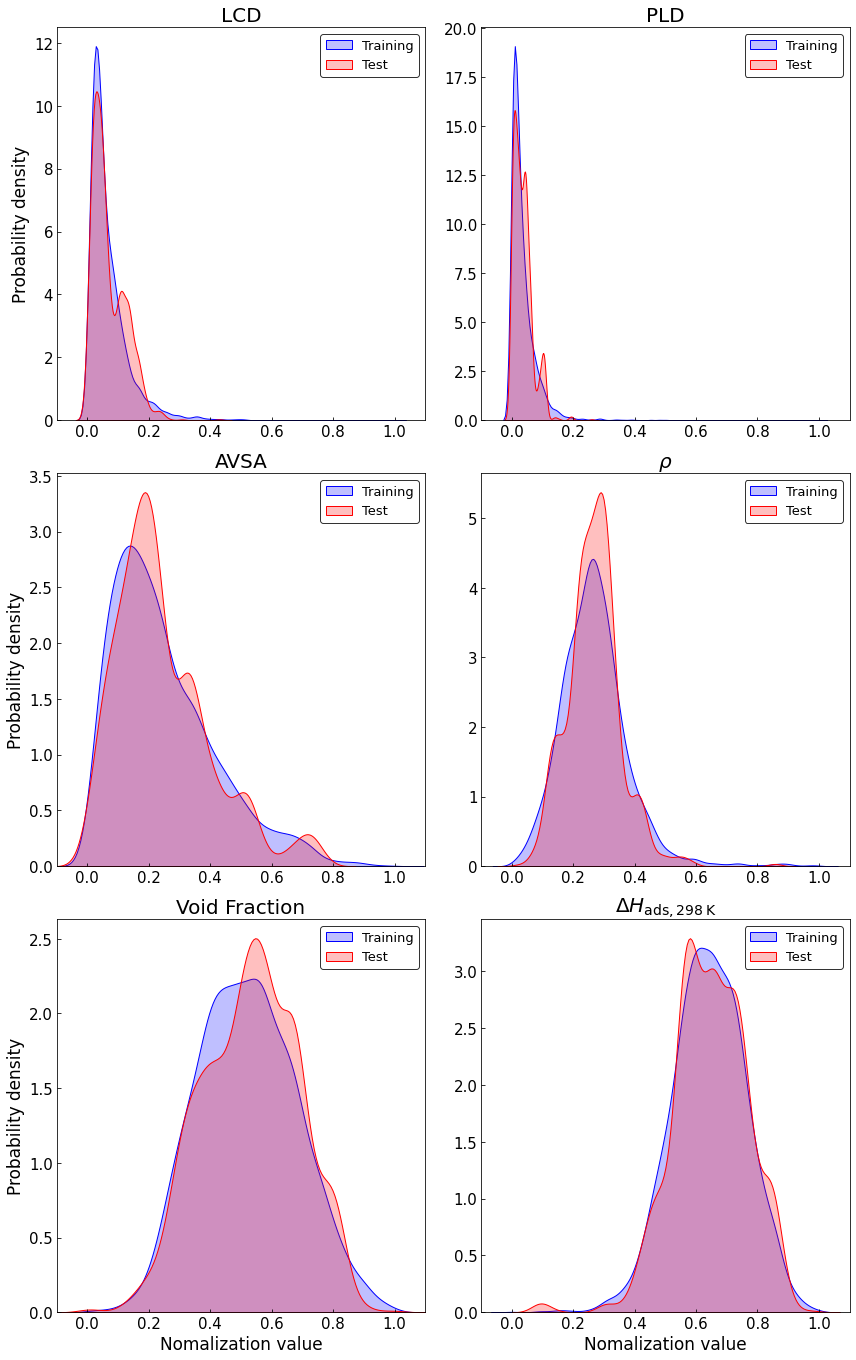

In [4]:

feature_0 = data.T[0]
feature_1 = data.T[1]
feature_2 = data.T[2]
feature_3 = data.T[3]
feature_4 = data.T[4]
feature_5 = data.T[5]
# rescale
feature_0 = (feature_0 - np.min(feature_0))/(np.max(feature_0) - np.min(feature_0))
feature_1 = (feature_1 - np.min(feature_1))/(np.max(feature_1) - np.min(feature_1))
feature_2 = (feature_2 - np.min(feature_2))/(np.max(feature_2) - np.min(feature_2))
feature_3 = (feature_3 - np.min(feature_3))/(np.max(feature_3) - np.min(feature_3))
feature_4 = (feature_4 - np.min(feature_4))/(np.max(feature_4) - np.min(feature_4))
feature_5 = (feature_5 - np.min(feature_5))/(np.max(feature_5) - np.min(feature_5))
if N_features == 5:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials)))
if N_features == 6:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials),feature_5.reshape(1,N_materials)))
if N_features == 7:
    x = np.concatenate((feature_0.reshape(1,N_materials),feature_1.reshape(1,N_materials),feature_2.reshape(1,N_materials),feature_3.reshape(1,N_materials),feature_4.reshape(1,N_materials),feature_5.reshape(1,N_materials),feature_6.reshape(1,N_materials)))
data=x.T
   
X_train = data[diverse_set]
X_test = data[remaining_set]

feature_list=['LCD', 'PLD', 'AVSA','$\mathit{\u03C1}$',  'Void Fraction',r'$\Delta\mathit{H}_{\mathrm{ads,298}}$$_{ }$$_{ }$$_{ }$$_\mathrm{ K}$']
fig=plt.figure(figsize=(12,19))
for i in range(feature_num):
    ax=plt.subplot(math.ceil(feature_num/2),2,i+1)
    ax.set_xlim(-0.1,1.1)
    if i%2==0:
        ax.set_ylabel("Probability density",fontsize=17)
    else:
        #ax.axes.yaxis.set_visible(True)
        ax.set_ylabel(" ",fontsize=3)
    if i > 3 :
        ax.set_xlabel("Nomalization value",fontsize=17)
    ax.set_title(feature_list[i],fontsize=20,position=(.5,1.01))
    #for axis in ['top','bottom','left','right']:
    #ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=15)
    sns.distplot(list(X_train.T[i]),ax=ax, color='b',label="Training",hist=False,bins='scott',norm_hist=True, kde_kws={"shade": True})
    sns.distplot(list(X_test.T[i]),ax=ax, color='r',label="Test",hist=False,bins='scott',norm_hist=True, kde_kws={"shade": True})
    plt.legend(frameon=True,fontsize=13,edgecolor='k',loc='best')
plt.tight_layout()
plt.savefig("feature_distribution"+"_"+str(feature_num)+"_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+file_name+"_.png",dpi=400)

## 3.1 Train model(Gradient Boosting Regression)  and Save training model

In [12]:
importances_list=[]


for j,case in enumerate(cases):
    ### Load target ###
    with open(data_file_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        target = np.empty((N_samples,len(cases)))
        temp = next(data_file) 
        for i, d in enumerate(data_file):
            target[i] = np.asarray(d[feature_num:], dtype=np.float64)
    
    y_train = target[diverse_set].T
    y_test = target[remaining_set].T
    ### Hyperparameter tuning ###

    reg = GradientBoostingRegressor(max_features='sqrt',random_state=40)
    space  = [Integer(1,1000, name='n_estimators'),
            Integer(1, 5, name='max_depth'),
             Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
             Integer(2, 100, name='min_samples_split'),
             Integer(1, 100, name='min_samples_leaf')]
    @use_named_args(space)
    
    def objective(**params):
        
        reg.set_params(**params)   
        
        return -np.mean(cross_val_score(reg, X_train, y_train[j], cv=5, n_jobs=-1,
                                            scoring="neg_mean_absolute_error"))
    
    res_gp = gp_minimize(objective, space, n_calls=100, random_state=40)
    
    print(case)
    print("Best score=%.4f" % res_gp.fun)
    print("""Best parameters:
        - n_estimator=%d
        - max_depth=%d
        - learning_rate=%.6f
        - min_samples_split=%d
        - min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                                    res_gp.x[2], res_gp.x[3],
                                    res_gp.x[4]))
    reg_opt = GradientBoostingRegressor(n_estimators=res_gp.x[0],
                                            max_depth=res_gp.x[1],
                                           learning_rate=res_gp.x[2],
                                           min_samples_split=res_gp.x[3],
                                           min_samples_leaf=res_gp.x[4],
                                           random_state=40,
                                           max_features='sqrt')
    reg_opt.fit(X_train, y_train[j])
    save_model = joblib.dump(reg_opt,"Methane_" + case + "_" + str(feature_num) + "_" + str(diverse_ratio) + "_" + str("%.1f"%remaining_ratio) +"_"+file_name+".pkl")
    print('R^2 Training Score: {:.3f} \nR^2 Testing Score: {:.3f}'.format(reg_opt.score(X_train, y_train[j]),reg_opt.score(X_test, y_test[j])))
    print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train[j],reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test[j],reg_opt.predict(X_test)))))
    print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train[j],reg_opt.predict(X_train)),mean_absolute_error(y_test[j],reg_opt.predict(X_test))))
    print([feature+" : "+str(reg_opt.feature_importances_[i]) for i,feature in enumerate(feature_list)])
    importances_list.append(list(reg_opt.feature_importances_))
    

LNG_ANG
Best score=16.4630
Best parameters:
        - n_estimator=661
        - max_depth=5
        - learning_rate=0.041815
        - min_samples_split=2
        - min_samples_leaf=1
R^2 Training Score: 0.982 
R^2 Testing Score: 0.969
RMSE Training Score: 12.297 
RMSE Testing Score: 17.197
MAE Training Score: 9.345 
MAE Testing Score: 12.411
['LCD : 0.22457588059815625', 'PLD : 0.027904911903188508', 'AVSA : 0.18029574659380096', '$\\mathit{ρ}$ : 0.20320858607685222', 'Void Fraction : 0.21143906317278438', '$\\Delta\\mathit{H}_{\\mathrm{ads,298}}$$_{ }$$_{ }$$_{ }$$_\\mathrm{ K}$ : 0.15257581165521755']
ANG
Best score=8.5639
Best parameters:
        - n_estimator=885
        - max_depth=5
        - learning_rate=0.038200
        - min_samples_split=2
        - min_samples_leaf=1
R^2 Training Score: 0.985 
R^2 Testing Score: 0.980
RMSE Training Score: 5.878 
RMSE Testing Score: 7.306
MAE Training Score: 4.560 
MAE Testing Score: 5.661
['LCD : 0.19424898422162995', 'PLD : 0.028687058258

## 3.2 Load feature importance from saved model

In [5]:
importances_list=[]
for case in cases:
    reg_opt= joblib.load("Methane_" + case + "_" + str(feature_num) + "_" + str(diverse_ratio) + "_" + str("%.1f"%remaining_ratio) +"_"+file_name+".pkl") 
    importances_list.append(list(reg_opt.feature_importances_))
print("Complete!")

Complete!


## 3.3 Plot feature importances

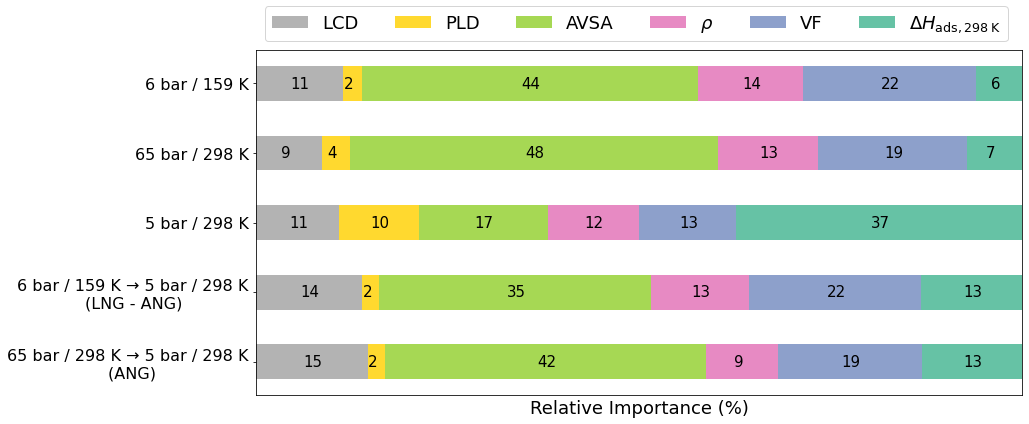

In [6]:
#6features
importances_list = [importances_list[3],importances_list[4],importances_list[2],importances_list[0],importances_list[1]]
titles=['6 bar / 159 K','65 bar / 298 K','5 bar / 298 K','6 bar / 159 K → 5 bar / 298 K\n(LNG - ANG)             ','65 bar / 298 K → 5 bar / 298 K\n(ANG)                  ']
features_6 = ['LCD', 'PLD',  'AVSA','$\mathit{\u03C1}$', 'VF',r'$\Delta\mathit{H}_{\mathrm{ads,298}}$$_{ }$$_{ }$$_{ }$$_\mathrm{ K}$']
color_map='Set2_r'
fig, ax = plt.subplots(figsize=(14.4,6))

ax.invert_yaxis()
ax.set_xticks([])
ax.tick_params(axis='x', which='both', direction='out',width=0)
category_colors = plt.get_cmap(color_map)(np.linspace(0.1,0.9,feature_num))
importances_list_remake=np.array(importances_list)
ax.set_xlim(0, np.sum(importances_list_remake, axis=1).max())
ax.set_xlabel("Relative Importance (%)",size=18)
for i ,(feature,color) in enumerate(zip(features_6,category_colors)):
    widths = importances_list_remake[:,i]
    starts = importances_list_remake.cumsum(axis=1)[:,i] - widths
    ax.barh(titles,importances_list_remake[:,i],left=starts, height =0.5,
        label=feature,color=color)
    xcenters = starts + widths / 2 - 0.011
    g,r,b,_=color
    text_color='k'
    for y,(x,c) in enumerate(zip(xcenters,widths)):
        ax.text(x,y,str(round(float(c*100))),ha='left',va='center',color=text_color,fontsize=15)    
    ax.legend(ncol=len(features_6),bbox_to_anchor=(0,1),
                loc='lower left', fontsize=18)
ax.tick_params(direction='out',labelsize=16)
plt.tight_layout()
plt.savefig('./GBR_'+str(diverse_ratio)+'_'+str("%.1f"%remaining_ratio)+'_'+str(feature_num)+'feature_'+file_name+'.png',dpi=600)
plt.show()
